# Chicago Food Inspections Data Pipeline

This notebook contains a complete data pipeline for processing, cleaning, analyzing, and storing Chicago Food Inspections data. The pipeline consists of several steps:

## Data Loading and Pre-processing
- Imports custom functions from the `data_preparation` module
- Loads food inspection data from CSV format
- Transforms column names for consistency
- Cleans and standardizes data fields:
    - License numbers
    - ZIP codes
    - Geographic information (city/state)
    - Missing coordinates (geocoding)
    - Risk categories
    - Business names
- Saves cleaned dataset to CSV for future use

## Data Profiling and Quality Checks
The pipeline performs various data quality checks:
- Profile business names for consistency
- Analyze risk levels distribution
- Validate inspection dates
- Examine inspection types
- Review inspection results
- Verify location data (ZIP codes, states)
- Check for proper mapping between ZIP/state/city
- Inspect violation data structure and content

## Database Normalization and Storage
The data is normalized into three main tables:
1. **Facility** - Information about food establishments
2. **Inspection** - Details about each inspection
3. **Violations** - Individual violations found during inspections

These tables are then stored in a SQLite database called `food_inspections.db`

## How to Run
1. Ensure you have the required dependencies installed (`pandas`, etc.)
2. Place the input CSV file (`Food_Inspections_20250216.csv`) in the working directory
3. Make sure the `data_preparation.py` module is available in your path
4. Execute the notebook cells in order
5. Review the profiling results to understand data quality
6. Access the normalized data in the SQLite database

The final database structure follows a star schema design that allows for efficient querying across inspection records, facilities, and violations.

In [1]:
from data_preparation import *

# Loading and preprocessing the data

In [2]:
food_dataset = pd.read_csv("Food_Inspections_20250216.csv",  dtype={'License #': str, 'Zip': str})
updated_food_dataset = food_dataset.copy()
updated_food_dataset = col_name_changer(updated_food_dataset)
updated_food_dataset = process_license_numbers(updated_food_dataset)
updated_food_dataset = clean_zip_data(updated_food_dataset).drop(columns=['zip','zip_valid'],axis=1).rename(columns={'zip_clean':'zip'})
updated_food_dataset['state'] = updated_food_dataset.apply(
    lambda row: row['state'] if pd.notna(row['state']) else get_zip_info(row['zip'],'state'),
    axis=1)
updated_food_dataset['city'] = updated_food_dataset.apply(
    lambda row: row['city'] if pd.notna(row['city']) else get_zip_info(row['zip'],'city'),
    axis=1)
updated_food_dataset = geocode_missing_coordinates(updated_food_dataset)
updated_food_dataset = risk_column_transformation(updated_food_dataset)
updated_food_dataset = standardize_name_columns(updated_food_dataset)
updated_food_dataset['aka_name'] = updated_food_dataset['aka_name'].fillna(updated_food_dataset['dba_name'])
updated_food_dataset = fix_city_name(updated_food_dataset)
updated_food_dataset.to_csv("cleaned_dataset_for_FD.csv", index=False)

# Profiling and data quality check

In [12]:
profile_name(updated_food_dataset)


Name Similarity Statistics
                                          Description    Value
missing_initial       Initial missing aka_name values        0
missing_filled   aka_name values filled with dba_name        0
exact_matches             Exact matches between names  211,890
similar_count         Similar names (above threshold)  238,958
avg_similarity               Average similarity score     0.90


(        inspection_id                            dba_name  \
 0             1106427                blooming bud daycare   
 1             2608378                         babas halal   
 2             1106406            first zabiha meat bazaar   
 3             2609909                        happy market   
 4             2609927          sat kaival food inc/subway   
 ...               ...                                 ...   
 287232        2610937            dapper's east restaurant   
 287233        2610845                           sharpie's   
 287234        2610409            ace sushi @potash market   
 287235        2610823                kitchen chicago, llc   
 287236        2610068  hannah's bretzel 227 w. monroe llc   
 
                           aka_name license_num       facility_type    risk  \
 0             blooming bud daycare     2215789  Daycare Combo 1586    High   
 1                      babas halal     2684170          Restaurant    High   
 2         first 

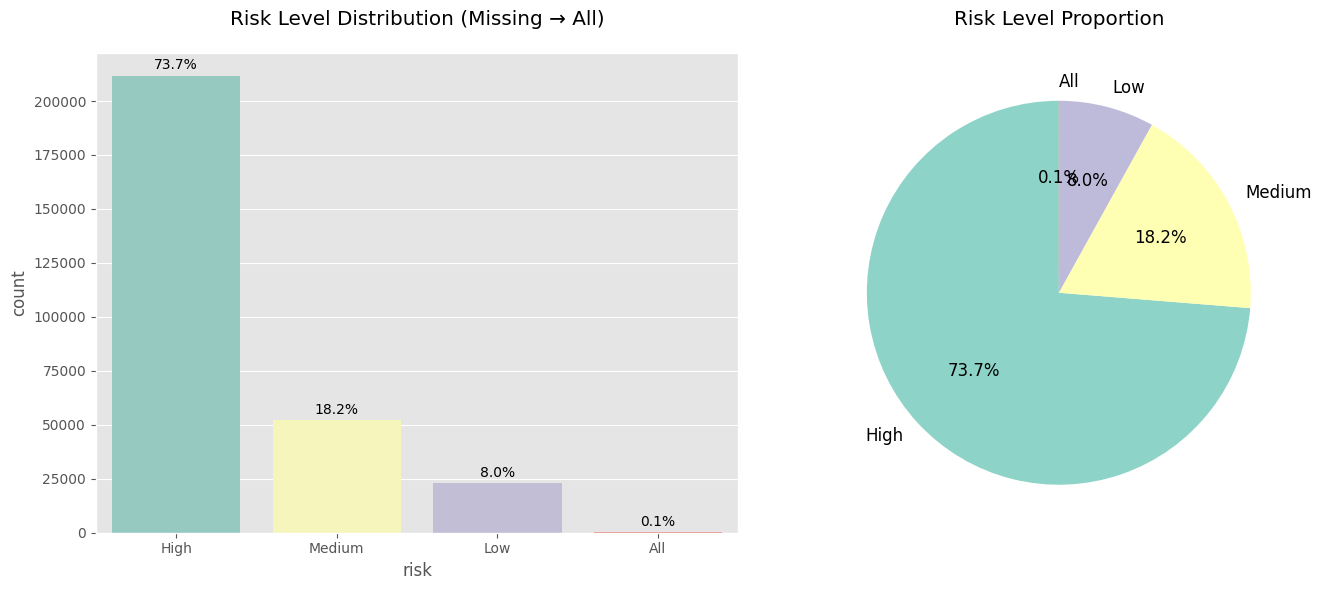

{'value_counts':          Count  Percentage
 risk                      
 High    211761       73.72
 Medium   52347       18.22
 Low      22973        8.00
 All        156        0.05,
 'invalid_values': array([], dtype=object),
 'pre_missing_count': 0,
 'invalid_count': 0}

In [13]:
profile_risk_column(updated_food_dataset)


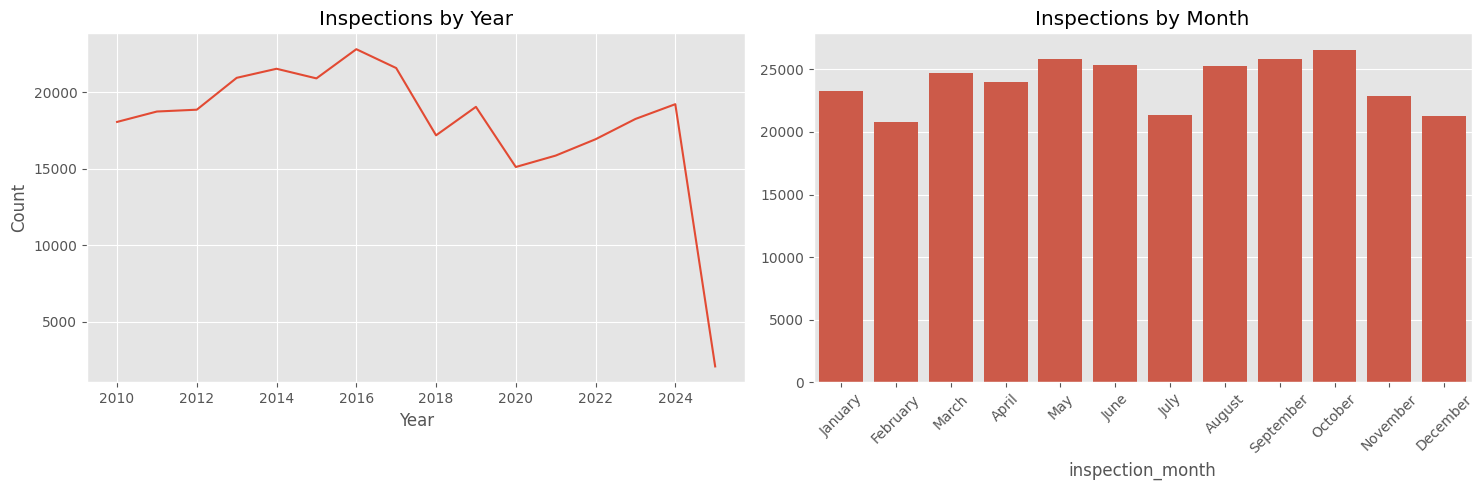

Date Range: 2010-01-04 to 2025-02-14
Most Active Year: 2016 (22,818 inspections)
Most Active Month: October (26,556 inspections)


In [14]:
profile_inspection_date(updated_food_dataset)


Standardized Inspection Type Distribution:
• Canvass                       : 149,450 (52.0%)
• License                       :  38,809 (13.5%)
• Complaint                     :  35,873 (12.5%)
• Canvass (Re-Inspection)       :  31,876 (11.1%)
• License (Re-Inspection)       :  12,006 (4.2%)
• Complaint (Re-Inspection)     :  11,332 (3.9%)
• Other                         :   5,660 (2.0%)
• Suspect Food Poisoning        :     977 (0.3%)
• Consultation                  :     697 (0.2%)
• Task-Force Inspection         :     337 (0.1%)
• Suspect Food Poisoning (Re-Inspection):     219 (0.1%)


/Users/giangson/coding/-DATA-PREPARATION-FOR-FOOD-INSPECTION/data_preparation.py:287: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


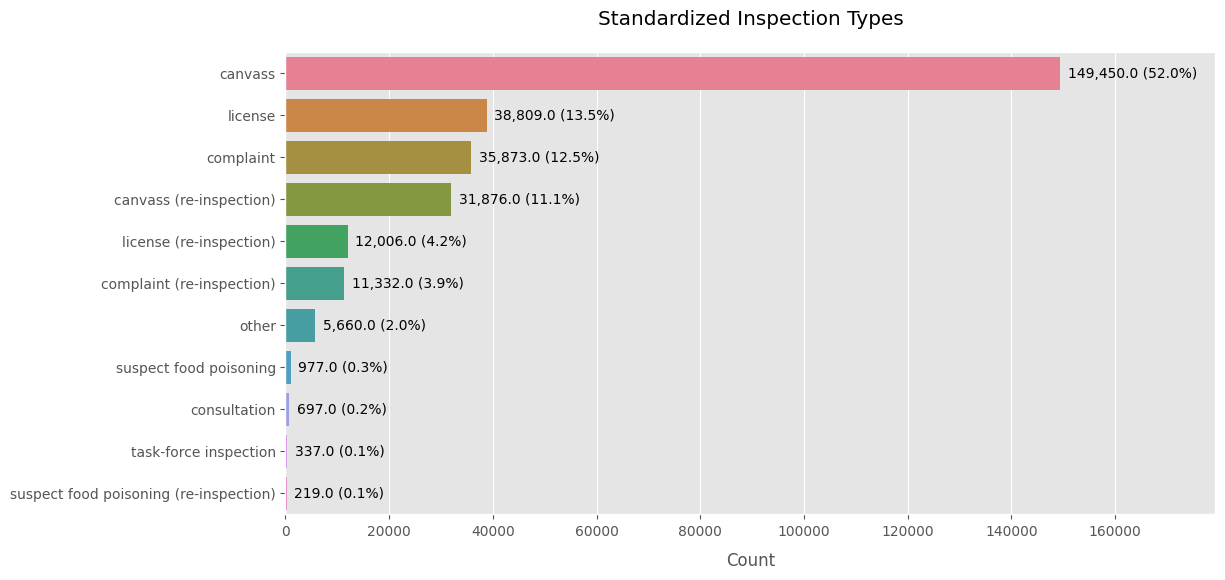

In [15]:
profile_inspection_type(updated_food_dataset)



Outcome Distribution Summary:
• Pass                :  148,027 (51.5%)
• Pass W/ Conditions  :   43,357 (15.1%)
• Fail                :   55,771 (19.4%)
• Out Of Business     :   24,078 (8.4%)
• No Entry            :   12,112 (4.2%)
• Not Ready           :    3,800 (1.3%)
• Business Not Located:       92 (0.0%)


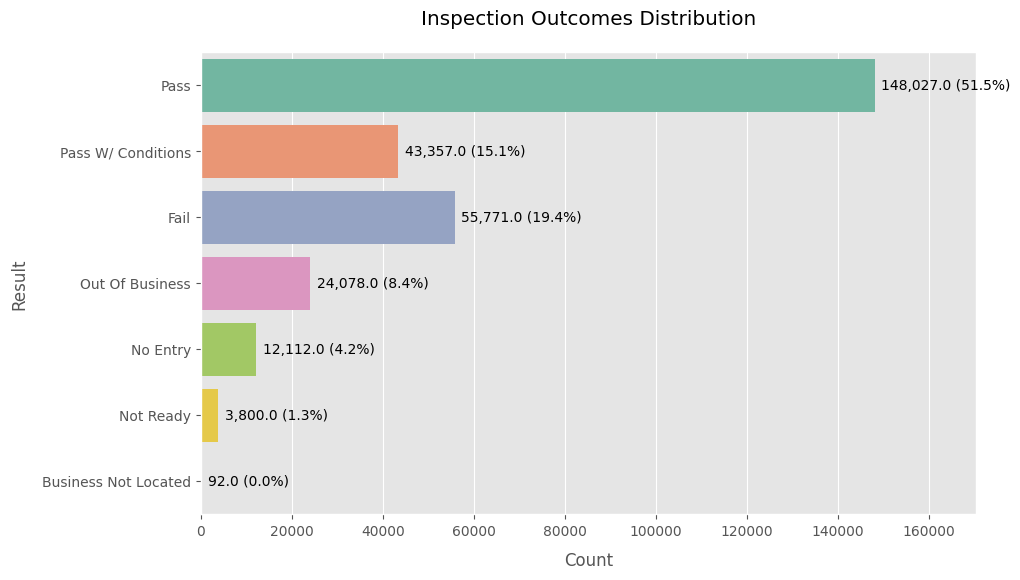

In [16]:
profile_results(updated_food_dataset)


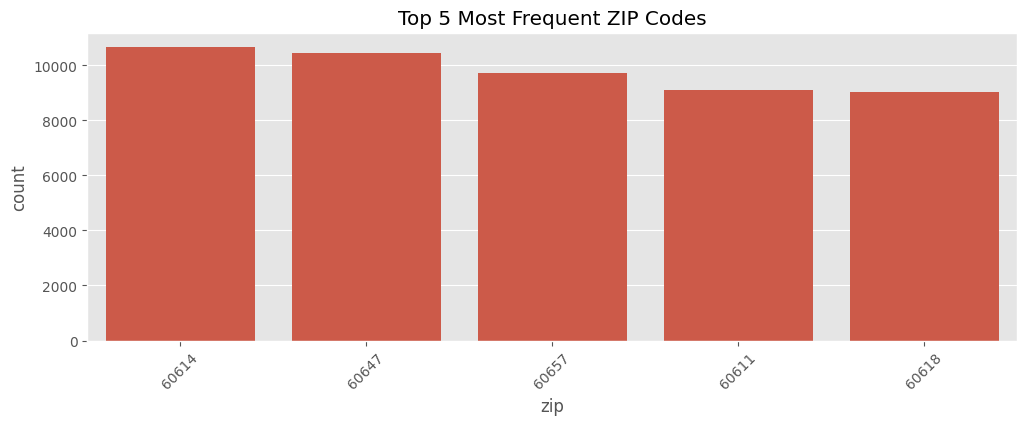

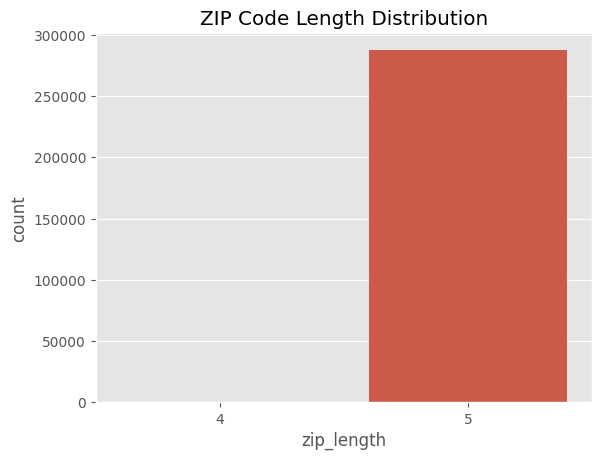

In [17]:
profile_zip(updated_food_dataset)


  State   Count  Percentage
0    IL  287222         1.0
1    IN      10         0.0
2    CA       2         0.0
3    CO       1         0.0
4    NY       1         0.0
5    WI       1         0.0


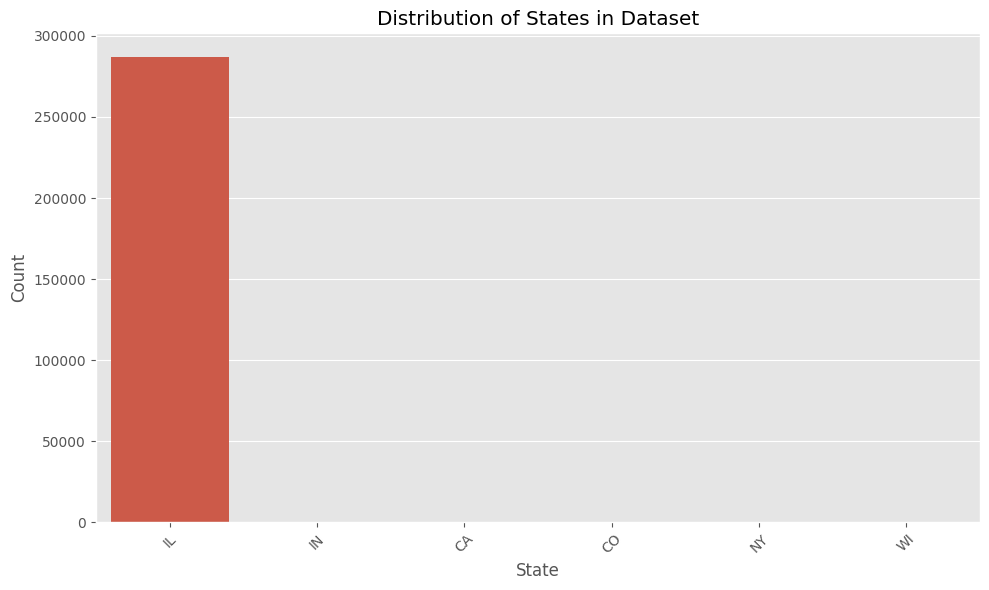

In [18]:
profile_state(updated_food_dataset)


In [19]:
check_zip_state_city_mapping(updated_food_dataset)


ZIPs with conflicting states: 0
Empty DataFrame
Columns: [zip, state, city]
Index: []


In [20]:
check_city_state_spelling(updated_food_dataset)


Potential duplicates for 'CHICAGO': ['CHICAGO', '312CHICAGO']


In [21]:
profile_violations(updated_food_dataset, sample_size=1000)


violations Column Structure Analysis:

Total Samples:
  1000

Avg Length:
  1841.554

Separator Counts:
  - |: 1842.554
  - .: 1841.554
  - -: 15.922
  - :: 9.85
  - ;: 1.581

Violation Counts:

Common Patterns:
  - 100.0% start with digits followed by period
  - 100.0% contain 'Comments:' text

Violations Per Entry:
  - min: 1
  - max: 28
  - avg: 7.555
  - distribution: {6: 98, 7: 96, 9: 93, 8: 83, 5: 83, 4: 78, 10: 78, 1: 74, 12: 58, 11: 53, 3: 52, 2: 44, 13: 27, 14: 22, 15: 21, 16: 14, 17: 10, 19: 8, 18: 3, 22: 2, 28: 1, 23: 1, 21: 1}


{'total_samples': 1000,
 'avg_length': 1841.554,
 'separator_counts': {'|': 1842.554,
  '.': 1841.554,
  '-': 15.922,
  ':': 9.85,
  ';': 1.581},
 'violation_counts': [],
 'common_patterns': ['100.0% start with digits followed by period',
  "100.0% contain 'Comments:' text"],
 'sample_entries': ['3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATURE REQUIREMENT DURING STORAGE, PREPARATION DISPLAY AND SERVICE - Comments: OBSERVED SAUSAGE PIZZA WITH APPROXIMATE WEIGHT APPROXIMATELY 1LB VALUED AT $5 AT 119.2 F AND CHEESEY BREAD APPROXIMATELY 1 LB VALUED AT $2.50 AT 109.4 F. FOOD DISPOSED OF AND DENATURED. CRITICAL VIOLATION 7-38-005 (A) | 33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: OBSERVED DOUGH MIXER EXTERIOR UNCLEAN. CLEAN AND MAINTAIN EXTERIOR OF MIXER IN SANITARY CONDITION. | 33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: OBSERVED SODA AND SLUSHY DRAINS UNSANITARY WITH HEAVY BUILDUP OF DIRT

In [22]:
verify_violations_structure(updated_food_dataset)


Violations Structure Verification Results:
{'total_checked': 207585, 'valid_entries': 207585, 'invalid_entries': 0, 'validity_percentage': 100.0, 'sample_invalid': []}


{'total_checked': 207585,
 'valid_entries': 207585,
 'invalid_entries': 0,
 'validity_percentage': 100.0,
 'sample_invalid': []}

# Normalizing and storage

In [23]:
##### INGESTING TO SQL DATABASE #####
violations_df = parse_violations(updated_food_dataset) # parse the violations, output a separate dataframe. read the docstring for more details
facility_df, inspection_df = create_normalized_tables(updated_food_dataset) # Create the normalized tables

# Save tables to SQLite database
df_to_sqlite(violations_df, 'food_inspections.db', 'violations', if_exists='replace', index=False)
df_to_sqlite(facility_df, 'food_inspections.db', 'facility', if_exists='replace', index=False)
df_to_sqlite(inspection_df, 'food_inspections.db', 'inspection', if_exists='replace', index=False)

Successfully saved DataFrame to food_inspections.db as table 'violations'
Table contains 937586 rows and 4 columns
Successfully saved DataFrame to food_inspections.db as table 'facility'
Table contains 46275 rows and 12 columns
Successfully saved DataFrame to food_inspections.db as table 'inspection'
Table contains 287237 rows and 6 columns


True

In [4]:
# example query to check the data in the database
query = """
SELECT v.violation_code, v.category, COUNT(*) as violation_count
FROM violations v
-- JOIN violations vc ON v.inspection_id = vc.inspection_id
GROUP BY v.violation_code
ORDER BY violation_count DESC
LIMIT 10
"""
# Run the query and display the result
query_to_df('food_inspections.db', query)

,violation_code,category,violation_count
0,38,VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQ...,72461
1,34,"FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD RE...",71698
2,55,"PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN",69851
3,33,FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS C...,66487
4,35,"WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTE...",65561
5,32,FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DE...,55172
6,41,WIPING CLOTHS: PROPERLY USED & STORED,39238
7,36,THERMOMETERS PROVIDED & ACCURATE,34335
8,47,"FOOD & NON-FOOD CONTACT SURFACES CLEANABLE, PR...",31591
9,3,POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATURE R...,26751


In [5]:
violations_df = parse_violations(updated_food_dataset) # parse the violations, output a separate dataframe. read the docstring for more details


/var/folders/cv/0cclzv3d1rd6v4byjw0t0n480000gn/T/ipykernel_16665/1910494008.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='code_category', data=code_category_counts, palette='viridis')


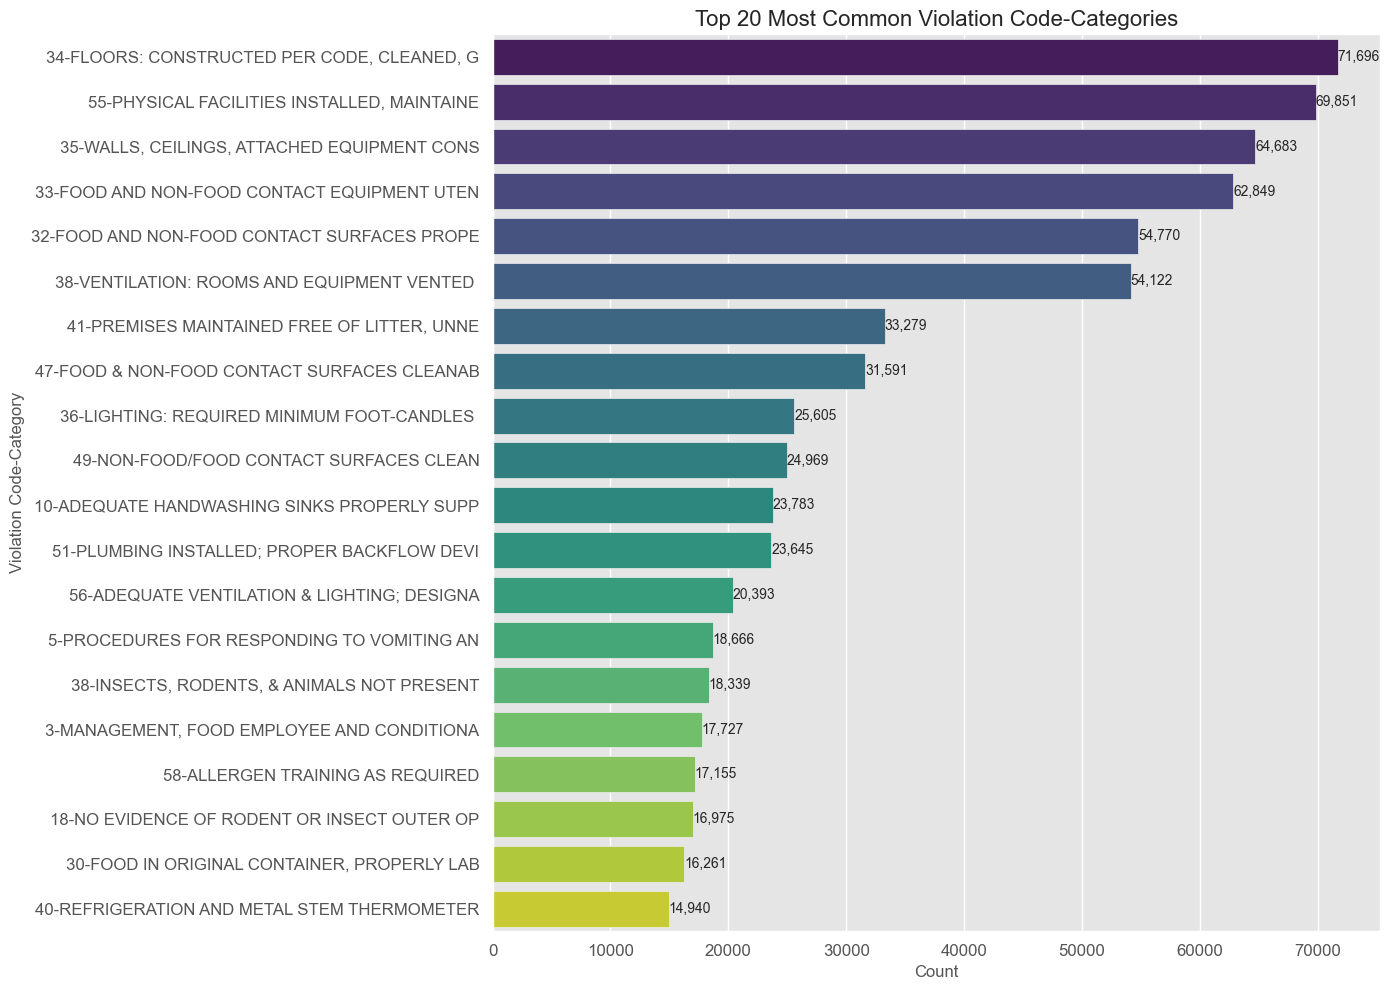

In [ ]:
import seaborn as sns


import matplotlib.pyplot as plt


def profile_violations(violations_df):
    '''
    Function to profile the violations data.
    '''
    # Get counts of each code_category and sort
    violations_df['code_category'] = violations_df['violation_code'].astype('str') + '-' + violations_df['category'].str[:40]
    code_category_counts = violations_df['code_category'].value_counts().reset_index()
    code_category_counts.columns = ['code_category', 'count']
    code_category_counts = code_category_counts.head(20)  # Top 20

    # Create figure with larger size for readability
    plt.figure(figsize=(14, 10))

    # Create horizontal bar chart
    sns.barplot(x='count', y='code_category', data=code_category_counts, palette='viridis')

    # Add title and labels
    plt.title('Top 20 Most Common Violation Code-Categories', fontsize=16)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Violation Code-Category', fontsize=12)
    plt.tight_layout()

    # Add count values at the end of each bar
    for i, v in enumerate(code_category_counts['count']):
        plt.text(v + 0.1, i, f"{v:,}", va='center')

    plt.show()
profile_violations(violations_df)

/var/folders/cv/0cclzv3d1rd6v4byjw0t0n480000gn/T/ipykernel_16665/1727757280.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='comment', data=top_comments, palette='viridis')


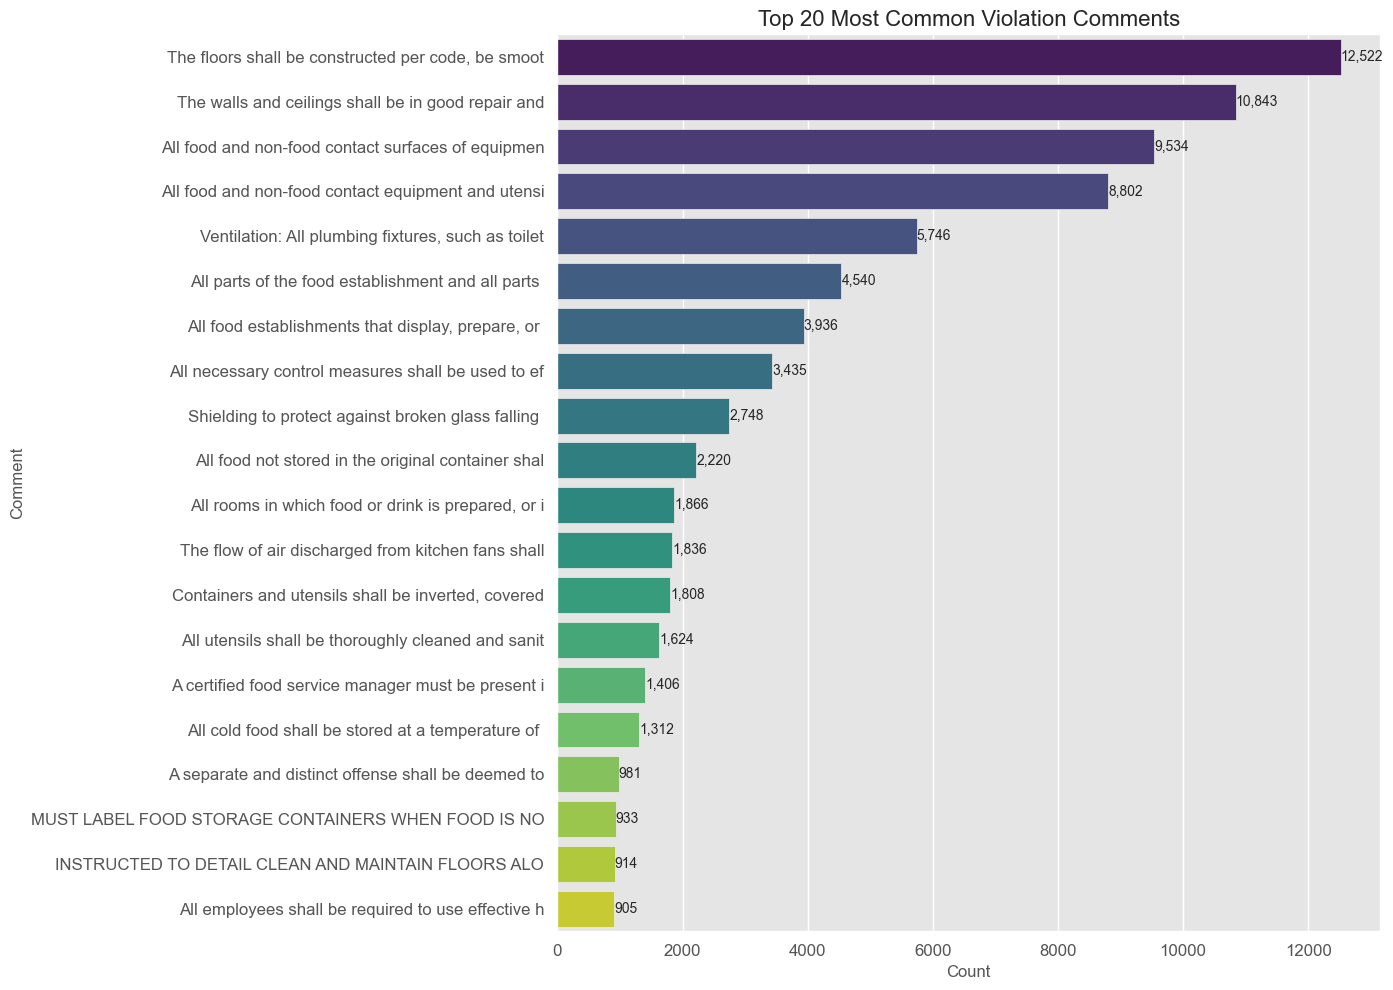

In [ ]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# Create a dataframe with comment frequencies
comment_counts = violations_df['comment'].str[:50].value_counts().reset_index()
comment_counts.columns = ['comment', 'count']
top_comments = comment_counts.head(20)

# Create a horizontal bar chart
plt.figure(figsize=(14, 10))
sns.barplot(x='count', y='comment', data=top_comments, palette='viridis')

plt.title('Top 20 Most Common Violation Comments', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Comment', fontsize=12)
plt.tight_layout()

# Add count values at the end of each bar
for i, v in enumerate(top_comments['count']):
    plt.text(v + 0.1, i, f"{v:,}", va='center')

plt.show()